<a href="https://colab.research.google.com/github/lucasgneccoh/BDSS_Dauphine/blob/main/notebooks/solutions/BDSS_TD_EQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bases de données semi-structurées - TD Exam

Main teacher: **Dario COLAZZO**

Teaching Assistant: **Lucas GNECCO**

Special thanks to **Beatrice NAPOLITANO**

Université Paris Dauphine - PSL

This notebook contains the questions and answers to the TD part of the exam about JSON and JSON in Postgres

# Database setup

## Install PostgreSQL


In [ ]:
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np



In [ ]:
%capture
# Taken from https://www.postgresql.org/download/linux/ubuntu/


# Create the file repository configuration:
!sudo sh -c 'echo "deb http://apt.postgresql.org/pub/repos/apt $(lsb_release -cs)-pgdg main" > /etc/apt/sources.list.d/pgdg.list'

# Import the repository signing key:
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -

# Update the package lists:
!sudo apt-get update

# Install the latest version of PostgreSQL.
# If you want a specific version, use 'postgresql-12' or similar instead of 'postgresql':
!sudo apt-get -y install postgresql-14

OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://apt.postgresql.org/pub/repos/apt bionic-pgdg InRelease [110 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [84.8 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http:

In [ ]:
!service postgresql start
!sudo -u postgres psql -c "CREATE USER root WITH SUPERUSER"
# set connection
%load_ext sql
%config SqlMagic.feedback=False 
%config SqlMagic.autopandas=True
%sql postgresql+psycopg2://@/postgres

 * Starting PostgreSQL 14 database server
   ...done.
CREATE ROLE


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


'Connected: @postgres'

In [ ]:
!psql -V

psql (PostgreSQL) 14.2 (Ubuntu 14.2-1.pgdg18.04+1)


## Create tables and insert data
Get the JSON version of the dataset
Then insert it in the PostgreSQL tables

In [ ]:
!wget "https://raw.githubusercontent.com/lucasgneccoh/BDSS_students/main/data/films.json"
FILMS = json.load(open("films.json", "r"))
print(*FILMS.keys())

--2022-05-03 12:44:19--  https://raw.githubusercontent.com/lucasgneccoh/BDSS_students/main/data/films.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39243 (38K) [text/plain]
Saving to: ‘films.json.1’

films.json.1        100%[===================>]  38.32K  --.-KB/s    in 0.003s  

2022-05-03 12:44:19 (10.8 MB/s) - ‘films.json.1’ saved [39243/39243]

arrArtistes arrFilms


In [ ]:
%%sql

DROP TABLE IF EXISTS artistsSQL;
DROP TABLE IF EXISTS filmsSQL; 

CREATE TABLE filmsSQL (
	id serial NOT NULL PRIMARY KEY,
	data json NOT NULL
);
CREATE TABLE artistsSQL (
	id serial NOT NULL PRIMARY KEY,
	data json NOT NULL
);

 * postgresql+psycopg2://@/postgres


Empty DataFrame
Columns: []
Index: []

In [ ]:
# Be careful with the ' character
a = "retrouve l'un de ses"
b = re.sub("\'","''", a)
print(b)

retrouve l''un de ses


In [ ]:
%%capture

for f in FILMS["arrArtistes"]:
    json_string = re.sub("\'","''", json.dumps(f))
    cmd = f'''INSERT INTO artistsSQL (data) VALUES('{json_string}')'''
    %sql $cmd;

for f in FILMS["arrFilms"]:
    json_string = re.sub("\'","''", json.dumps(f))
    cmd = f'''INSERT INTO filmsSQL (data) VALUES('{json_string}')'''
    %sql $cmd;

## Make simple SELECT statements to see if the data is right

In [ ]:
%%sql
SELECT *
FROM artistsSQL
LIMIT 3
;

 * postgresql+psycopg2://@/postgres


id                                               data
0   1  {'ACTNOM': 'Cameron', 'ACTPNOM': 'James', 'ANN...
1   2  {'ACTNOM': 'Hitchcock', 'ACTPNOM': 'Alfred', '...
2   3  {'ACTNOM': 'Scott', 'ACTPNOM': 'Ridley', 'ANNE...

In [ ]:
%%sql
SELECT data -> 'ACTNOM' as nom,
        data -> 'ACTPNOM' as prenom,
        data -> 'ANNEENAISS' as anneN
FROM artistsSQL
WHERE CAST(data ->> 'ANNEENAISS' as INTEGER) > 1950
LIMIT 5
;

 * postgresql+psycopg2://@/postgres


nom   prenom annen
0   Cameron    James  1954
1  Travolta     John  1954
2      Cage  Nicolas  1964
3    Burton      Tim  1958
4    Willis    Bruce  1955

# Exercises

Now that we have our data in PostgreSQL we can do a lot of things!

We can do almost everything we know in standard SQL if we are able to create the right tables from our JSON data.

On top of that, PostgreSQL has a lot of functions to deal with JSON objects that make this approach a lot easier and powerful.

Here are some examples and documentation that can be helpful:


https://www.postgresqltutorial.com/postgresql-json/

https://www.postgresql.org/docs/current/functions-json.html



## Exercise 1: Simple queries we already know

Do queries 2, 4 and 8. They should not be that hard

Query 2: Films released in 1980

Query 4: Films with Bruce Willis in it

Query 8: Role of Harvey Keitel in Reservoir Dogs


If you want something a bit more challenging, try to do someething general. For example in Query 4, what if I want to look for some other artist?

In [ ]:
# Query 2: Films released in 1980

%%sql
SELECT data -> 'TITRE' -> 'title' as title,
        CAST(data ->> 'Annee' as INTEGER) as year
FROM filmsSQL
WHERE CAST(data ->> 'Annee' as INTEGER) = 1980
;

 * postgresql+psycopg2://@/postgres


title  year
0  Kagemusha  1980
1    Shining  1980

In [ ]:
# Query 4: Films with Bruce Willis in it
%%sql
SELECT  title, year,
        roles -> 'INTITULE' as intitule
FROM (
    SELECT  data -> 'TITRE' -> 'title' as title,
            CAST(data ->> 'Annee' as INTEGER) as year,
            json_array_elements ( data -> 'ROLES' )  as roles
    FROM filmsSQL
    
) AS TMP

WHERE LOWER(roles ->> 'NOM') LIKE 'willis' AND LOWER(roles ->> 'PRENOM') LIKE 'bruce' 
;

 * postgresql+psycopg2://@/postgres


title  year            intitule
0          Piège de cristal  1988             McClane
1     58 minutes pour vivre  1990              McLane
2  L'armée des douze singes  1995                Cole
3              Pulp fiction  1994      Butch Coolidge
4      Le cinquième élément  1997  Major Korben Dalla

In [ ]:
prenom, nom = 'bruce', 'willis'

query = f"""
SELECT  title, year,
        roles -> 'INTITULE' as intitule
FROM (
    SELECT  data -> 'TITRE' -> 'title' as title,
            CAST(data ->> 'Annee' as INTEGER) as year,
            json_array_elements ( data -> 'ROLES' )  as roles
    FROM filmsSQL
    
) AS TMP

WHERE LOWER(roles ->> 'NOM') LIKE '{nom}' AND LOWER(roles ->> 'PRENOM') LIKE '{prenom}' 
"""

%sql $query;

 * postgresql+psycopg2://@/postgres


title  year            intitule
0          Piège de cristal  1988             McClane
1     58 minutes pour vivre  1990              McLane
2  L'armée des douze singes  1995                Cole
3              Pulp fiction  1994      Butch Coolidge
4      Le cinquième élément  1997  Major Korben Dalla

In [ ]:
# Query 8: Role of Harvey Keitel in Reservoir Dogs

%%sql
SELECT  title, year,
        roles -> 'INTITULE' as intitule
FROM (
    SELECT  data -> 'TITRE' -> 'title' as title,
            CAST(data ->> 'Annee' as INTEGER) as year,
            json_array_elements ( data -> 'ROLES' )  as roles
    FROM filmsSQL
    WHERE LOWER(data -> 'TITRE' ->> 'title') LIKE 'reservoir dogs'
    
) AS TMP

WHERE LOWER(roles ->> 'NOM') LIKE 'keitel' AND LOWER(roles ->> 'PRENOM') LIKE 'harvey' 
;

 * postgresql+psycopg2://@/postgres


title  year         intitule
0  Reservoir dogs  1992  Mr. White/Larry

## Exercise 2: More complex queries we have maybe talked about

Let's use the nice SQL syntax to JOIN the two tables we have (films and artists)

### Exercise 2.1: For every movie, show its title, year and the information about the director

In [ ]:
# '''
#     First get the artist data in a normal table
# '''
%%sql

SELECT  data ->> 'ACTPNOM' as prenom,
        data ->> 'ACTNOM' as nom,
        data ->> 'ANNEENAISS' as yearBirth,
        data ->> 'id_art' as id_art
FROM artistsSQL
;

 * postgresql+psycopg2://@/postgres


prenom        nom yearbirth id_art
0          James    Cameron      1954     _6
1         Alfred  Hitchcock      1899     _3
2         Ridley      Scott      1937     _4
3      Sigourney     Weaver      None     _5
4           Kate   Winslett      None     _8
..           ...        ...       ...    ...
112          Ian       Holm      1931   _117
113      Natalie    Portman      None   _118
114         Anne  Parillaud      1960   _119
115  Jean-Hughes    Anglade      1955   _120
116    Jean-Marc       Barr      1960   _121

[117 rows x 4 columns]

In [ ]:
# '''
#     Do the same with the films
# '''
%%sql

SELECT  data ->> 'Annee' as yearFilm,
        data -> 'TITRE' ->> 'title' as title,
        data ->> 'MES' as id_art
FROM filmsSQL
LIMIT 5
;

 * postgresql+psycopg2://@/postgres


yearfilm       title id_art
0     1958     Vertigo     _3
1     1979       Alien     _4
2     1997     Titanic     _6
3     1986   Sacrifice     _9
4     1997  Volte/Face    _10

In [ ]:
# '''
#     Join them. Remember the basic JOIN syntax
#     SELECT table1.column1, table2.column2...
#     FROM table1
#     INNER JOIN table2
#     ON table1.common_filed = table2.common_field;
# '''
%%sql
SELECT title, yearFilm, prenom, nom FROM
    (
        SELECT  data ->> 'ACTPNOM' as prenom,
                data ->> 'ACTNOM' as nom,
                data ->> 'ANNEENAISS' as yearBirth,
                data ->> 'id_art' as id_art
        FROM artistsSQL
    ) as TMP_ART 
    INNER JOIN
    ( 
        SELECT  data ->> 'Annee' as yearFilm,
                data -> 'TITRE' ->> 'title' as title,
                data ->> 'MES' as id_art
        FROM filmsSQL
    ) as TMP_FILMS
    ON TMP_ART.id_art = TMP_FILMS.id_art
;

### Exercise 2.2: For each artist, count the participations on any film (as actor, not as a director)

In [ ]:
%%sql

SELECT prenom, nom, COUNT(*) as num_roles
FROM
    (
        SELECT  title, year,
                roles ->> 'PRENOM' as prenom,
                roles ->> 'NOM' as nom,
                roles ->> 'INTITULE' as intitule
        FROM (
            SELECT  data -> 'TITRE' -> 'title' as title,
                    CAST(data ->> 'Annee' as INTEGER) as year,
                    json_array_elements ( data -> 'ROLES' )  as roles
            FROM filmsSQL
        ) AS TMP
    ) as TMP2
GROUP BY prenom, nom
ORDER BY num_roles DESC
;

###  Exercise 2.3: For each artist, compute the average year of the films in which he/she has participated

In [ ]:
%%sql

SELECT prenom, nom, ROUND(AVG(year),2) as avgYear
FROM
    (
        SELECT  title, year,
                roles ->> 'PRENOM' as prenom,
                roles ->> 'NOM' as nom,
                roles ->> 'INTITULE' as intitule
        FROM (
            SELECT  data -> 'TITRE' ->> 'title' as title,
                    CAST(data ->> 'Annee' as INTEGER) as year,
                    json_array_elements ( data -> 'ROLES' )  as roles
            FROM filmsSQL
        ) AS TMP
    ) as TMP2
GROUP BY prenom, nom
ORDER BY avgYear DESC
;

 * postgresql+psycopg2://@/postgres


prenom        nom  avgyear
0       Russell      Crowe  2000.00
1   Christopher     Walken  1999.00
2      Laurence  Fishburne  1999.00
3         Keanu     Reeves  1999.00
4        Anette     Bening  1999.00
..          ...        ...      ...
79         Cary      Grant  1959.00
80        James      Mason  1959.00
81    Eva Marie      Saint  1959.00
82          Kim      Novak  1958.00
83        James    Stewart  1958.00

[84 rows x 3 columns]

###  Exercise 2.4: For each artist and each participation in a film, compute the age the artist had when he participated in the movie.

Filter out NaN values !

In [ ]:
%%sql

SELECT title, TMP_FILMS.prenom, TMP_FILMS.nom, TMP_FILMS.yearFilm, yearBirth, yearFilm - yearBirth as age  
FROM
(
    (
        SELECT  data ->> 'ACTPNOM' as prenom,
                data ->> 'ACTNOM' as nom,
                CAST(data ->> 'ANNEENAISS' as INTEGER) as yearBirth,
                data ->> 'id_art' as id_art
        FROM artistsSQL
    ) as TMP_ART 
    INNER JOIN
    ( 
        SELECT  title, yearFilm,
                roles ->> 'PRENOM' as prenom,
                roles ->> 'NOM' as nom,
                roles ->> 'INTITULE' as intitule
        FROM (
                SELECT  data -> 'TITRE' ->> 'title' as title,
                        CAST(data ->> 'Annee' as INTEGER) as yearFilm,
                        json_array_elements ( data -> 'ROLES' )  as roles
                FROM filmsSQL
            ) AS TMP
    ) as TMP_FILMS
    ON TMP_ART.nom = TMP_FILMS.nom AND TMP_ART.prenom = TMP_FILMS.prenom
)
WHERE yearBirth <> double precision 'NaN'
ORDER BY TMP_FILMS.nom, TMP_FILMS.prenom
;

 * postgresql+psycopg2://@/postgres


title       prenom       nom  yearfilm  yearbirth  age
0                     Nikita  Jean-Hughes   Anglade      1990       1955   35
1              Le grand bleu      Rosanna  Arquette      1988       1959   29
2               Pulp fiction      Rosanna  Arquette      1994       1959   35
3         Les frères pétards      Josiane   Balasko      1986       1950   36
4    Les bronzés font du ski      Josiane   Balasko      1979       1950   29
..                       ...          ...       ...       ...        ...  ...
78      Le cinquième élément        Bruce    Willis      1997       1955   42
79  L'armée des douze singes        Bruce    Willis      1995       1955   40
80     58 minutes pour vivre        Bruce    Willis      1990       1955   35
81          Piège de cristal        Bruce    Willis      1988       1955   33
82                   Titanic         Kate   Winslet      1997       1975   22

[83 rows x 6 columns]

## Exercise 3: New dataset with more complex data

We have worked a lot with the films dataset. Now we will consider a dataset about airline delays in US airports.

In [ ]:
!wget "https://raw.githubusercontent.com/lucasgneccoh/BDSS_students/main/data/airlines.json"
airports_json = json.load(open("airlines.json", "r"))

--2022-03-16 13:58:46--  https://raw.githubusercontent.com/lucasgneccoh/BDSS_students/main/data/airlines.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4964701 (4.7M) [text/plain]
Saving to: ‘airlines.json’

airlines.json       100%[===================>]   4.73M  --.-KB/s    in 0.1s    

2022-03-16 13:58:47 (33.7 MB/s) - ‘airlines.json’ saved [4964701/4964701]



In [ ]:
%%sql

DROP TABLE IF EXISTS airports; 

CREATE TABLE airports (
	id serial NOT NULL PRIMARY KEY,
	airport json NOT NULL,
    time json NOT NULL,
    statistics json NOT NULL
);



 * postgresql+psycopg2://@/postgres


Empty DataFrame
Columns: []
Index: []

In [ ]:
# Before populating the table we need to make some adjustments to the names

def lower_dict(d, key_func = lambda k: k.lower(), leaf_func = lambda x: x):
    # Leaf value, can do a simple tranformation
    if not isinstance(d, dict):
        return leaf_func(d)
    
    # Not leaf
    aux = {}
    for k, v in d.items():
        aux[key_func(k)] = lower_dict(v, key_func = key_func,  leaf_func = leaf_func)

    return aux

def key_func(s):
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    s = s.replace("#", "num")
    s = s.lower()
    return s


airports_json_corrected = []
for i, a in enumerate(airports_json):
    aux = lower_dict(a, key_func = key_func, leaf_func = lambda x: x)
    aux["id"] =  i
    airports_json_corrected.append(aux)

print(*airports_json_corrected[0])

airport time statistics id


In [ ]:
%%capture
import re
for a in airports_json_corrected:
    json_string = re.sub("\'","''", json.dumps(a))
    cmd = f"""INSERT INTO airports SELECT * FROM json_populate_record(null::airports, '{json_string}')""";
    %sql $cmd

Lets see if the table is populated correctly

In [ ]:
%%sql

SELECT * FROM airports LIMIT 5;

 * postgresql+psycopg2://@/postgres


id                                            airport  \
0   0  {'code': 'ATL', 'name': 'Atlanta, GA: Hartsfie...   
1   1  {'code': 'BOS', 'name': 'Boston, MA: Logan Int...   
2   2  {'code': 'BWI', 'name': 'Baltimore, MD: Baltim...   
3   3  {'code': 'CLT', 'name': 'Charlotte, NC: Charlo...   
4   4  {'code': 'DCA', 'name': 'Washington, DC: Ronal...   

                                                time  \
0  {'label': '2003/06', 'month': 6, 'month_name':...   
1  {'label': '2003/06', 'month': 6, 'month_name':...   
2  {'label': '2003/06', 'month': 6, 'month_name':...   
3  {'label': '2003/06', 'month': 6, 'month_name':...   
4  {'label': '2003/06', 'month': 6, 'month_name':...   

                                          statistics  
0  {'num_of_delays': {'carrier': 1009, 'late_airc...  
1  {'num_of_delays': {'carrier': 374, 'late_aircr...  
2  {'num_of_delays': {'carrier': 296, 'late_aircr...  
3  {'num_of_delays': {'carrier': 300, 'late_aircr...  
4  {'num_of_delays': {'carrier': 283, 'late_aircr...

### Exercise 3.1: Simple data extraction

From this dataset that we have loaded, get a simpler table with the following colums

airport code, airport name, year, month, cancelled flights

***TIP***: Put a LIMIT to the query so that you don't get all the results on the screen

In [ ]:
%%sql

SELECT  (airport ->> 'code' ) as a_code,
        (airport ->> 'name' ) as a_name,
        (time ->> 'year' ) as year,
        (time ->> 'month' ) as month,
        (statistics -> 'flights' ->> 'cancelled') as numCancelled
FROM airports
LIMIT 10;

 * postgresql+psycopg2://@/postgres


a_code                                             a_name  year month  \
0    ATL  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...  2003     6   
1    BOS                    Boston, MA: Logan International  2003     6   
2    BWI  Baltimore, MD: Baltimore/Washington Internatio...  2003     6   
3    CLT     Charlotte, NC: Charlotte Douglas International  2003     6   
4    DCA  Washington, DC: Ronald Reagan Washington National  2003     6   
5    DEN                   Denver, CO: Denver International  2003     6   
6    DFW  Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...  2003     6   
7    DTW            Detroit, MI: Detroit Metro Wayne County  2003     6   
8    EWR           Newark, NJ: Newark Liberty International  2003     6   
9    FLL  Fort Lauderdale, FL: Fort Lauderdale-Hollywood...  2003     6   

  numcancelled  
0          216  
1          138  
2           29  
3           73  
4           74  
5           34  
6          394  
7          123  
8          102  
9           13

### Exercise 3.2: Manipulating strings

Notice from the last query that the airport name is formatted in a special way. We want to see the cancelled flights by state, so we need to extract the state from the airport name.

For example from `Boston, MA: Logan International` we want to extract `MA`

Modify the last query to get a column with the state

See this documentation for some tips

https://www.postgresql.org/docs/current/functions-string.html


In [ ]:
%%sql

SELECT  (airport ->> 'code' ) as a_code,
        (airport ->> 'name' ) as a_name,
        substring((airport ->> 'name' ) from '.*,\s+(.*):.*') as state,
        (time ->> 'year' ) as year,
        (time ->> 'month' ) as month,
        (statistics -> 'flights' ->> 'cancelled') as numCancelled
FROM airports
LIMIT 10;

 * postgresql+psycopg2://@/postgres


a_code                                             a_name state  year month  \
0    ATL  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...    GA  2003     6   
1    BOS                    Boston, MA: Logan International    MA  2003     6   
2    BWI  Baltimore, MD: Baltimore/Washington Internatio...    MD  2003     6   
3    CLT     Charlotte, NC: Charlotte Douglas International    NC  2003     6   
4    DCA  Washington, DC: Ronald Reagan Washington National    DC  2003     6   
5    DEN                   Denver, CO: Denver International    CO  2003     6   
6    DFW  Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...    TX  2003     6   
7    DTW            Detroit, MI: Detroit Metro Wayne County    MI  2003     6   
8    EWR           Newark, NJ: Newark Liberty International    NJ  2003     6   
9    FLL  Fort Lauderdale, FL: Fort Lauderdale-Hollywood...    FL  2003     6   

  numcancelled  
0          216  
1          138  
2           29  
3           73  
4           74  
5           34  
6          394  
7          123  
8          102  
9           13

Now with the state in the table, count the number of cancelled flights by state for all periods.

In [ ]:
%%sql


SELECT  substring((airport ->> 'name' ) from '.*,\s+(.*):.*') as state,
        SUM( CAST(statistics -> 'flights' ->> 'cancelled' as INTEGER) ) as numCancelled
FROM airports
GROUP BY state
ORDER BY numCancelled DESC
LIMIT 10;

 * postgresql+psycopg2://@/postgres


state  numcancelled
0    IL        159232
1    TX        111698
2    NY         87900
3    GA         86176
4    CA         80667
5    DC         56170
6    NJ         54880
7    FL         41178
8    MA         38652
9    CO         35926

We got all the cancelled flights in total. But some states have more airports and population than others. A better measure would be to compute the fraction of cancelled flights over all the flights. Do this by state

In [ ]:
%%sql

SELECT state, ROUND((numCancelled * 100.0) / total , 2) as fraction
FROM (
    SELECT  substring((airport ->> 'name' ) from '.*,\s+(.*):.*') as state,
            SUM( CAST(statistics -> 'flights' ->> 'cancelled' as DECIMAL) ) as numCancelled,
            SUM( CAST(statistics -> 'flights' ->> 'total' as INTEGER) ) as total
    FROM airports
    GROUP BY state
) as TMP
ORDER BY fraction DESC
LIMIT 10;

 * postgresql+psycopg2://@/postgres


state fraction
0    NJ     3.29
1    NY     3.19
2    IL     2.98
3    DC     2.68
4    MA     2.59
5    PA     2.02
6    TX     1.86
7    MI     1.73
8    GA     1.69
9    NC     1.54

### Exercise 3.3: Plots using pandas

We are going to make an interactive plot to see the evolution of delay reasons across time in a given airport or state. To do so we need first to get a table with the following columns: month, year, airport, state, and either a two more columns with delay_cause and num_delays, or one column for each delay type having as value the number of delays

In [ ]:
%%sql
CREATE TYPE delays AS (carrier int, late_aircraft int, national_aviation_system int, security int, weather int);

 * postgresql+psycopg2://@/postgres


Empty DataFrame
Columns: []
Index: []

In [ ]:
%%sql
SELECT  (time ->> 'year' ) as year,
        (time ->> 'month' ) as month,
        (airport ->> 'code' ) as a_code,
        substring((airport ->> 'name' ) from '.*,\s+(.*):.*') as state,
        (json_populate_record(null::delays, statistics -> 'num_of_delays')).*
FROM airports
WHERE CAST((time ->> 'year' ) as INTEGER) < 2016
LIMIT 10;

 * postgresql+psycopg2://@/postgres


year month a_code state  carrier  late_aircraft  national_aviation_system  \
0  2003     6    ATL    GA     1009           1275                      3217   
1  2003     6    BOS    MA      374            495                       685   
2  2003     6    BWI    MD      296            477                       389   
3  2003     6    CLT    NC      300            472                       735   
4  2003     6    DCA    DC      283            268                       487   
5  2003     6    DEN    CO      516            323                       664   
6  2003     6    DFW    TX      986           1390                      2147   
7  2003     6    DTW    MI      376            371                       570   
8  2003     6    EWR    NJ      322            519                      1948   
9  2003     6    FLL    FL      247            256                       427   

   security  weather  
0        17      328  
1         3       66  
2         8       78  
3         2       54  
4         4       58  
5        11       98  
6        19      258  
7         6       71  
8        10      121  
9         5       34

In [ ]:
# The last code works, we just need to put in in a pandas DataFrame to work with it

cmd = """ SELECT  (time ->> 'year' ) as year,
                    (time ->> 'month' ) as month,
                    (airport ->> 'code' ) as a_code,
                    substring((airport ->> 'name' ) from '.*,\s+(.*):.*') as state,
                    (json_populate_record(null::delays, statistics -> 'num_of_delays')).*            
            FROM airports
            WHERE CAST((time ->> 'year' ) as INTEGER) < 2016
            ;"""

df_delays = %sql $cmd
df_delays

 * postgresql+psycopg2://@/postgres


year month a_code state  carrier  late_aircraft  \
0     2003     6    ATL    GA     1009           1275   
1     2003     6    BOS    MA      374            495   
2     2003     6    BWI    MD      296            477   
3     2003     6    CLT    NC      300            472   
4     2003     6    DCA    DC      283            268   
...    ...   ...    ...   ...      ...            ...   
4374  2015    12    SAN    CA      480            606   
4375  2015    12    SEA    WA      518            742   
4376  2015    12    SFO    CA      757           1180   
4377  2015    12    SLC    UT      483            796   
4378  2015    12    TPA    FL      476            480   

      national_aviation_system  security  weather  
0                         3217        17      328  
1                          685         3       66  
2                          389         8       78  
3                          735         2       54  
4                          487         4       58  
...                        ...       ...      ...  
4374                       256         5       37  
4375                       767        13       50  
4376                      2372         9      147  
4377                       404         5       56  
4378                       287         4       43  

[4379 rows x 9 columns]

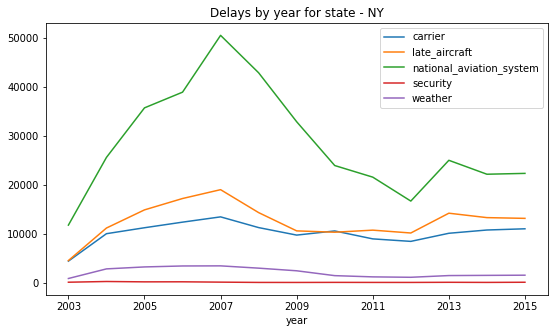

In [ ]:
state = "NY" #@param {type:"string"}
airport_code = "TPA" #@param {type:"string"}
filter_by_state = True #@param {type:"boolean"}

if filter_by_state:
    k, v = "state", state
else:
    k, v = "a_code", airport_code

cols_keep = ["year", "carrier", "late_aircraft", "national_aviation_system", "security", "weather"]

df_filter = df_delays[k] == v


fig, ax = plt.subplots(1, 1, figsize = (9, 5))
df_delays.loc[df_filter, cols_keep].groupby(by = "year").aggregate(func = sum).plot(ax = ax)
ax.set_title(f"Delays by year for {k} - {v}");

In [ ]:
# https://www.bts.dot.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations#:~:text=Delays%20or%20cancellations%20coded%20%22NAS,of%20total%20delays%20in%202020.

### Exercise 3.4: JSONPath in PostgresSQL
We can easily transform our table into a JSOn object and perform JSONPath queries on it


https://github.com/obartunov/sqljsondoc/blob/master/jsonpath.md

In [ ]:
%%sql

DROP TABLE IF EXISTS jsTable; 

CREATE TABLE jsTable(js jsonb);

INSERT INTO jsTable  
    SELECT json_agg(airports) FROM airports
;

 * postgresql+psycopg2://@/postgres


Empty DataFrame
Columns: []
Index: []

Lets see an example of a JSONPath query on this simple table with one JSON object inside. We want the JSON objects in the main array that correspond to a year before 2010

In [ ]:
%%sql
SELECT jsonb_path_query(js, '$[*] ? (@.time.year < 2010)') as airport_records
FROM jsTable
LIMIT 5
;

 * postgresql+psycopg2://@/postgres


airport_records
0  {'id': 0, 'time': {'year': 2003, 'label': '200...
1  {'id': 1, 'time': {'year': 2003, 'label': '200...
2  {'id': 2, 'time': {'year': 2003, 'label': '200...
3  {'id': 3, 'time': {'year': 2003, 'label': '200...
4  {'id': 4, 'time': {'year': 2003, 'label': '200...

Lets get a table with the airport, the month, the year and the delays for airports that had Alaska Airlines operating 


In [ ]:
%%sql
SELECT airport, time, statistics -> 'num_of_delays' as delays, statistics -> 'carriers' ->> 'names' as carriers
FROM airports
WHERE statistics::jsonb @? '$.carriers ? (@.names like_regex "alaska" flag "i")'
;

 * postgresql+psycopg2://@/postgres


airport  \
0     {'code': 'BOS', 'name': 'Boston, MA: Logan Int...   
1     {'code': 'DCA', 'name': 'Washington, DC: Ronal...   
2     {'code': 'DEN', 'name': 'Denver, CO: Denver In...   
3     {'code': 'EWR', 'name': 'Newark, NJ: Newark Li...   
4     {'code': 'IAD', 'name': 'Washington, DC: Washi...   
...                                                 ...   
2673  {'code': 'SAN', 'name': 'San Diego, CA: San Di...   
2674  {'code': 'SEA', 'name': 'Seattle, WA: Seattle/...   
2675  {'code': 'SFO', 'name': 'San Francisco, CA: Sa...   
2676  {'code': 'SLC', 'name': 'Salt Lake City, UT: S...   
2677  {'code': 'TPA', 'name': 'Tampa, FL: Tampa Inte...   

                                                   time  \
0     {'label': '2003/06', 'month': 6, 'month_name':...   
1     {'label': '2003/06', 'month': 6, 'month_name':...   
2     {'label': '2003/06', 'month': 6, 'month_name':...   
3     {'label': '2003/06', 'month': 6, 'month_name':...   
4     {'label': '2003/06', 'month': 6, 'month_name':...   
...                                                 ...   
2673  {'label': '2016/01', 'month': 1, 'month_name':...   
2674  {'label': '2016/01', 'month': 1, 'month_name':...   
2675  {'label': '2016/01', 'month': 1, 'month_name':...   
2676  {'label': '2016/01', 'month': 1, 'month_name':...   
2677  {'label': '2016/01', 'month': 1, 'month_name':...   

                                                 delays  \
0     {'carrier': 374, 'late_aircraft': 495, 'nation...   
1     {'carrier': 283, 'late_aircraft': 268, 'nation...   
2     {'carrier': 516, 'late_aircraft': 323, 'nation...   
3     {'carrier': 322, 'late_aircraft': 519, 'nation...   
4     {'carrier': 320, 'late_aircraft': 295, 'nation...   
...                                                 ...   
2673  {'carrier': 280, 'late_aircraft': 397, 'nation...   
2674  {'carrier': 357, 'late_aircraft': 513, 'nation...   
2675  {'carrier': 560, 'late_aircraft': 947, 'nation...   
2676  {'carrier': 338, 'late_aircraft': 540, 'nation...   
2677  {'carrier': 410, 'late_aircraft': 342, 'nation...   

                                               carriers  
0     American Airlines Inc.,Alaska Airlines Inc.,Co...  
1     American Airlines Inc.,Alaska Airlines Inc.,Co...  
2     American Airlines Inc.,Alaska Airlines Inc.,Je...  
3     American Airlines Inc.,Alaska Airlines Inc.,Co...  
4     American Airlines Inc.,Alaska Airlines Inc.,Je...  
...                                                 ...  
2673  American Airlines Inc.,Alaska Airlines Inc.,Je...  
2674  American Airlines Inc.,Alaska Airlines Inc.,Je...  
2675  American Airlines Inc.,Alaska Airlines Inc.,Je...  
2676  American Airlines Inc.,Alaska Airlines Inc.,Je...  
2677  American Airlines Inc.,Alaska Airlines Inc.,Je...  

[2678 rows x 4 columns]

## Exercise 4: Rick and Morty

Check https://rickandmortyapi.com/documentation for the documentation about the API and the schemas for the different JSON objects returned by the API

In [ ]:
import requests
res = requests.get("https://rickandmortyapi.com/api")
data = {}
for k, url in res.json().items():
    res2 = requests.get(url).json()
    # Get first page
    data[k] = res2['results']
    while not res2['info']['next'] is None:
        res2 = requests.get(res2['info']['next']).json()
        # Get first page
        data[k].extend(res2['results'])


In [ ]:
for k, v in data.items():
    print(k, len(v))
    print(v[0])

characters 826
{'id': 1, 'name': 'Rick Sanchez', 'status': 'Alive', 'species': 'Human', 'type': '', 'gender': 'Male', 'origin': {'name': 'Earth (C-137)', 'url': 'https://rickandmortyapi.com/api/location/1'}, 'location': {'name': 'Citadel of Ricks', 'url': 'https://rickandmortyapi.com/api/location/3'}, 'image': 'https://rickandmortyapi.com/api/character/avatar/1.jpeg', 'episode': ['https://rickandmortyapi.com/api/episode/1', 'https://rickandmortyapi.com/api/episode/2', 'https://rickandmortyapi.com/api/episode/3', 'https://rickandmortyapi.com/api/episode/4', 'https://rickandmortyapi.com/api/episode/5', 'https://rickandmortyapi.com/api/episode/6', 'https://rickandmortyapi.com/api/episode/7', 'https://rickandmortyapi.com/api/episode/8', 'https://rickandmortyapi.com/api/episode/9', 'https://rickandmortyapi.com/api/episode/10', 'https://rickandmortyapi.com/api/episode/11', 'https://rickandmortyapi.com/api/episode/12', 'https://rickandmortyapi.com/api/episode/13', 'https://rickandmortyapi.com

### Exercise 4.1: Create PostgreSQL tables with the data

In [ ]:
%%sql
DROP TABLE IF EXISTS characters;
DROP TABLE IF EXISTS locations;
DROP TABLE IF EXISTS episodes; 

CREATE TABLE characters (
	id serial NOT NULL PRIMARY KEY,
	data json NOT NULL
);
CREATE TABLE locations (
	id serial NOT NULL PRIMARY KEY,
	data json NOT NULL
);

CREATE TABLE episodes (
	id serial NOT NULL PRIMARY KEY,
	data json NOT NULL
);



 * postgresql+psycopg2://@/postgres


Empty DataFrame
Columns: []
Index: []

In [ ]:
%%capture
for k, arr in data.items():
    for v in arr:
        json_string = re.sub("\'","''", json.dumps(v))
        cmd = f'''INSERT INTO {k} (data) VALUES('{json_string}')'''
        %sql $cmd;

In [ ]:
%%sql

SELECT * FROM characters LIMIT 3;

 * postgresql+psycopg2://@/postgres


id                                               data
0   1  {'id': 1, 'name': 'Rick Sanchez', 'status': 'A...
1   2  {'id': 2, 'name': 'Morty Smith', 'status': 'Al...
2   3  {'id': 3, 'name': 'Summer Smith', 'status': 'A...

### Exercise 4.2: Count character interactions

For every pair of characters, count the times they appear together in an episode

In [ ]:
# Explode the episodes table to contain one record per character
# char contains the url to the character, so no name or description is yet available !
%%sql
SELECT  data ->> 'id' as id_ep,
        data ->> 'name' as name,
        CAST(json_array_elements(data -> 'characters') as TEXT) as char
    FROM episodes

In [ ]:
# Get from the characters table the id and the url of each character
%%sql
SELECT  data ->> 'id' as id_char,
        CAST(data -> 'url' AS TEXT) as url
    FROM characters
;

In [ ]:
# Join tables to get the character name into the episode data

%%sql

DROP TABLE IF EXISTS explode_ep_char;

CREATE TABLE explode_ep_char AS
SELECT * FROM
(
    SELECT  data ->> 'id' as id_ep,
            data ->> 'name' as name,
            CAST(json_array_elements(data -> 'characters') as TEXT) as char
    FROM episodes
) as A INNER JOIN 
(
    SELECT  data ->> 'id' as id_char,
            CAST(data -> 'url' AS TEXT) as url
    FROM characters
) as B
ON A.char = B.url
;

SELECT  *
FROM  explode_ep_char
LIMIT 2
; 

In [ ]:
# Now that we have the data, can join the exploded episode table with itself
# To filter, we enforce that the characters appear on the same episode and that
# the character id is different without duplicates using the < comparison
%%sql

SELECT  A.id_ep, A.name, A.id_char as c1, A.url as u1, B.id_char as c2, B.url as u2
FROM 
explode_ep_char as A INNER JOIN explode_ep_char as B
ON A.id_ep = B.id_ep AND A.id_char < B.id_char 
LIMIT 6
;

In [ ]:
# Now we can group by the columns containing the character ids and count

%%sql

SELECT c1, c2, count(*) as count FROM
(
    SELECT  A.id_ep, A.name, A.id_char as c1, A.url as u1, B.id_char as c2, B.url as u2
    FROM 
    explode_ep_char as A INNER JOIN explode_ep_char as B
    ON A.id_ep = B.id_ep AND A.id_char < B.id_char
) as T
GROUP BY c1, c2
ORDER BY count DESC
;

### Exercise 4.3: Episode appereances

For every character, count the episodes it appears in

In [ ]:
# With the table we created on the last exercise this is straightforward
%%sql

SELECT id_char, count(*)
FROM explode_ep_char
GROUP BY id_char
ORDER BY count DESC 
LIMIT 10;

### Exercise 4.4: Gender and species of characters by episode

Count, for each episode, the number of characters of each gender that appear. To do this by species should be straightforward

In [ ]:
# Similar to 4.2, we explode the episode table including the per character information
# needed

%%sql

DROP TABLE IF EXISTS explode_ep_char_info;

CREATE TABLE explode_ep_char_info AS
SELECT * FROM
(
    SELECT  CAST(data ->> 'id' AS INTEGER) as ep_id,
            data ->> 'name' as ep_name,
            CAST(json_array_elements(data -> 'characters') as TEXT) as ep_char
    FROM episodes
) as A INNER JOIN 
(
    SELECT  data ->> 'id' as char_id,
            CAST(data -> 'url' AS TEXT) as char_url,
            data ->> 'species' as char_species,
            data ->> 'type' as char_type,
            data -> 'origin'->> 'name' as char_origin
    FROM characters
) as B
ON A.ep_char = B.char_url
;

SELECT  *
FROM  explode_ep_char_info
LIMIT 3
; 

 * postgresql+psycopg2://@/postgres


ep_id                  ep_name  \
0     23    Rickmancing the Stone   
1     39  The Vat of Acid Episode   
2     38               Promortyus   

                                         ep_char char_id  \
0  "https://rickandmortyapi.com/api/character/1"       1   
1  "https://rickandmortyapi.com/api/character/1"       1   
2  "https://rickandmortyapi.com/api/character/1"       1   

                                        char_url char_species char_type  \
0  "https://rickandmortyapi.com/api/character/1"        Human             
1  "https://rickandmortyapi.com/api/character/1"        Human             
2  "https://rickandmortyapi.com/api/character/1"        Human             

     char_origin  
0  Earth (C-137)  
1  Earth (C-137)  
2  Earth (C-137)

In [ ]:
%%sql

SELECT ep_id, ep_name, char_species, COUNT(*) as count
FROM explode_ep_char_info
GROUP BY ep_id, ep_name, char_species
ORDER BY ep_id
LIMIT 5
;

 * postgresql+psycopg2://@/postgres


ep_id        ep_name           char_species  count
0      1          Pilot                  Alien      6
1      1          Pilot                  Human      9
2      1          Pilot             Cronenberg      4
3      2  Lawnmower Dog  Mythological Creature      6
4      2  Lawnmower Dog                 Animal      4

### Exercise 4.5: Dimension of character by episode

For each episode and the characters that were there, get the dimension from their location of origin. Then make the count of different origins by episode.

In [ ]:
%%sql

SELECT ep_id, ep_name, char_origin, COUNT(*) as count
FROM explode_ep_char_info
GROUP BY ep_id, ep_name, char_origin
ORDER BY ep_id
LIMIT 15
;

 * postgresql+psycopg2://@/postgres


ep_id                 ep_name                    char_origin  count
0       1                   Pilot                      Girvonesk      1
1       1                   Pilot                  Earth (C-137)     11
2       1                   Pilot                        unknown      5
3       1                   Pilot                 Gromflom Prime      1
4       1                   Pilot                        Bepis 9      1
5       2           Lawnmower Dog                Snuffles' Dream      2
6       2           Lawnmower Dog  Earth (Replacement Dimension)      1
7       2           Lawnmower Dog                  Earth (C-137)      7
8       2           Lawnmower Dog         Mr. Goldenfold's dream      5
9       2           Lawnmower Dog                        unknown      4
10      3            Anatomy Park                        unknown      3
11      3            Anatomy Park                   Anatomy Park      6
12      3            Anatomy Park                  Earth (C-137)     15
13      4  M. Night Shaym-Aliens!                        unknown      5
14      4  M. Night Shaym-Aliens!                  Earth (C-137)      8